In [1]:
import numpy as np
import pandas as pd
import joblib

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading our inputs for training**

In [3]:
df_inputs = torch.load('tensors/df_inputs.pt')
df_inputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0021, 0.0014,  ..., 0.0008, 0.0012, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

**B. Loading our targets for training**

In [4]:
df_targets = torch.load('tensors/df_targets.pt')
df_targets

tensor([1, 2, 1,  ..., 0, 1, 1])

**C. Loading our inputs for testing**

In [5]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**D. Loading our targets for testing**

In [6]:
y_test1 = torch.load('tensors/y_test.pt')
y_test1

tensor([1, 2, 2,  ..., 1, 2, 1])

**E. Train-test Split**

In [7]:
X_train, X_test, y_train, y_test2 = train_test_split(df_inputs, df_targets, test_size=0.2, random_state=21, stratify=df_targets)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 50312
# Test data samples: 12579


In [8]:
X_train.shape

torch.Size([50312, 5000])

In [9]:
X_test.shape

torch.Size([12579, 5000])

In [10]:
y_train.shape

torch.Size([50312])

In [11]:
y_test2.shape

torch.Size([12579])

**F. Creating our Neural Network Architecture**

In [12]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [13]:
# Create an instance of the model and send it to target device
model_2 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_2

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [14]:
learning_rate_2 = 0.0001
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)
batch_size = 128

In [15]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

**G. Training the Network**

In [16]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_2 = MyCustomDataset(x=X_train, y=y_train)

train_loader = DataLoader(
    custom_dataset_2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 300
losses_2 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses_2.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_2.state_dict() }
torch.save(state, "./torch_models/model_2.pth")

Epoch: 0


100%|██████████| 394/394 [00:03<00:00, 114.87it/s, loss=1.07]


Ave Loss: 1.0814401392404198
Epoch: 1


100%|██████████| 394/394 [00:03<00:00, 129.79it/s, loss=1.02] 


Ave Loss: 1.0159514612957912
Epoch: 2


100%|██████████| 394/394 [00:02<00:00, 133.10it/s, loss=0.969]


Ave Loss: 0.9318964497994651
Epoch: 3


100%|██████████| 394/394 [00:03<00:00, 125.96it/s, loss=0.924]


Ave Loss: 0.858681785273673
Epoch: 4


100%|██████████| 394/394 [00:03<00:00, 124.67it/s, loss=0.884]


Ave Loss: 0.8017107137871272
Epoch: 5


100%|██████████| 394/394 [00:03<00:00, 121.24it/s, loss=0.844]


Ave Loss: 0.7578233925219114
Epoch: 6


100%|██████████| 394/394 [00:02<00:00, 146.24it/s, loss=0.804]


Ave Loss: 0.7235525313972822
Epoch: 7


100%|██████████| 394/394 [00:02<00:00, 168.60it/s, loss=0.764]


Ave Loss: 0.6963339801972288
Epoch: 8


100%|██████████| 394/394 [00:02<00:00, 169.17it/s, loss=0.725]


Ave Loss: 0.6743536111969634
Epoch: 9


100%|██████████| 394/394 [00:02<00:00, 164.87it/s, loss=0.688]


Ave Loss: 0.6563127411501056
Epoch: 10


100%|██████████| 394/394 [00:02<00:00, 161.39it/s, loss=0.652]


Ave Loss: 0.6412811963086201
Epoch: 11


100%|██████████| 394/394 [00:02<00:00, 135.09it/s, loss=0.619]


Ave Loss: 0.6285739385234523
Epoch: 12


100%|██████████| 394/394 [00:03<00:00, 107.14it/s, loss=0.588]


Ave Loss: 0.6176809202596015
Epoch: 13


100%|██████████| 394/394 [00:02<00:00, 135.16it/s, loss=0.559]


Ave Loss: 0.608222632314348
Epoch: 14


100%|██████████| 394/394 [00:02<00:00, 135.70it/s, loss=0.532]


Ave Loss: 0.5999079477514713
Epoch: 15


100%|██████████| 394/394 [00:02<00:00, 140.30it/s, loss=0.507]


Ave Loss: 0.5925162280271501
Epoch: 16


100%|██████████| 394/394 [00:02<00:00, 139.57it/s, loss=0.484]


Ave Loss: 0.5858764785346646
Epoch: 17


100%|██████████| 394/394 [00:02<00:00, 135.99it/s, loss=0.462]


Ave Loss: 0.5798552850176235
Epoch: 18


100%|██████████| 394/394 [00:02<00:00, 138.74it/s, loss=0.442]


Ave Loss: 0.5743471073922772
Epoch: 19


100%|██████████| 394/394 [00:02<00:00, 134.80it/s, loss=0.422]


Ave Loss: 0.5692629601598391
Epoch: 20


100%|██████████| 394/394 [00:02<00:00, 138.22it/s, loss=0.404]


Ave Loss: 0.5645454165899209
Epoch: 21


100%|██████████| 394/394 [00:02<00:00, 140.87it/s, loss=0.387]


Ave Loss: 0.5601422065103114
Epoch: 22


100%|██████████| 394/394 [00:03<00:00, 120.43it/s, loss=0.371]


Ave Loss: 0.5560081379516476
Epoch: 23


100%|██████████| 394/394 [00:02<00:00, 133.82it/s, loss=0.355]


Ave Loss: 0.5521054242921964
Epoch: 24


100%|██████████| 394/394 [00:02<00:00, 148.42it/s, loss=0.341]


Ave Loss: 0.5484052354157879
Epoch: 25


100%|██████████| 394/394 [00:02<00:00, 162.42it/s, loss=0.327]


Ave Loss: 0.5448785984727937
Epoch: 26


100%|██████████| 394/394 [00:02<00:00, 154.42it/s, loss=0.314]


Ave Loss: 0.5415075952329006
Epoch: 27


100%|██████████| 394/394 [00:02<00:00, 161.21it/s, loss=0.302]


Ave Loss: 0.5382771165994218
Epoch: 28


100%|██████████| 394/394 [00:02<00:00, 154.08it/s, loss=0.291]


Ave Loss: 0.5351800724183242
Epoch: 29


100%|██████████| 394/394 [00:02<00:00, 161.37it/s, loss=0.28] 


Ave Loss: 0.532198849743998
Epoch: 30


100%|██████████| 394/394 [00:02<00:00, 151.91it/s, loss=0.27] 


Ave Loss: 0.5293240063081538
Epoch: 31


100%|██████████| 394/394 [00:02<00:00, 159.30it/s, loss=0.26] 


Ave Loss: 0.5265499355678026
Epoch: 32


100%|██████████| 394/394 [00:02<00:00, 151.05it/s, loss=0.251]


Ave Loss: 0.5238606120426643
Epoch: 33


100%|██████████| 394/394 [00:02<00:00, 158.32it/s, loss=0.243]


Ave Loss: 0.5212545756458631
Epoch: 34


100%|██████████| 394/394 [00:02<00:00, 155.60it/s, loss=0.235]


Ave Loss: 0.5187258756327146
Epoch: 35


100%|██████████| 394/394 [00:02<00:00, 155.16it/s, loss=0.227]


Ave Loss: 0.5162697530488678
Epoch: 36


100%|██████████| 394/394 [00:02<00:00, 153.67it/s, loss=0.22] 


Ave Loss: 0.5138801141136189
Epoch: 37


100%|██████████| 394/394 [00:02<00:00, 160.35it/s, loss=0.214]


Ave Loss: 0.5115505695569939
Epoch: 38


100%|██████████| 394/394 [00:02<00:00, 163.52it/s, loss=0.208]


Ave Loss: 0.5092763132250249
Epoch: 39


100%|██████████| 394/394 [00:02<00:00, 154.28it/s, loss=0.202]


Ave Loss: 0.5070527714445506
Epoch: 40


100%|██████████| 394/394 [00:02<00:00, 157.58it/s, loss=0.196]


Ave Loss: 0.5048797003508825
Epoch: 41


100%|██████████| 394/394 [00:02<00:00, 155.05it/s, loss=0.191]


Ave Loss: 0.5027514084190281
Epoch: 42


100%|██████████| 394/394 [00:02<00:00, 154.67it/s, loss=0.186]


Ave Loss: 0.5006674794376199
Epoch: 43


100%|██████████| 394/394 [00:02<00:00, 156.04it/s, loss=0.182]


Ave Loss: 0.49862365091815214
Epoch: 44


100%|██████████| 394/394 [00:02<00:00, 154.54it/s, loss=0.178]


Ave Loss: 0.49662363862023134
Epoch: 45


100%|██████████| 394/394 [00:02<00:00, 147.14it/s, loss=0.174]


Ave Loss: 0.4946563868277569
Epoch: 46


100%|██████████| 394/394 [00:02<00:00, 159.53it/s, loss=0.17] 


Ave Loss: 0.4927222546435855
Epoch: 47


100%|██████████| 394/394 [00:02<00:00, 157.66it/s, loss=0.167]


Ave Loss: 0.4908191970535341
Epoch: 48


100%|██████████| 394/394 [00:02<00:00, 153.90it/s, loss=0.164]


Ave Loss: 0.4889480894819129
Epoch: 49


100%|██████████| 394/394 [00:02<00:00, 164.02it/s, loss=0.161]


Ave Loss: 0.4871079180446373
Epoch: 50


100%|██████████| 394/394 [00:02<00:00, 150.04it/s, loss=0.158]


Ave Loss: 0.4852944956666927
Epoch: 51


100%|██████████| 394/394 [00:02<00:00, 160.42it/s, loss=0.155]


Ave Loss: 0.4835070921533604
Epoch: 52


100%|██████████| 394/394 [00:02<00:00, 165.61it/s, loss=0.152]


Ave Loss: 0.48174561885407735
Epoch: 53


100%|██████████| 394/394 [00:02<00:00, 169.79it/s, loss=0.15] 


Ave Loss: 0.4800082159223895
Epoch: 54


100%|██████████| 394/394 [00:02<00:00, 166.53it/s, loss=0.147]


Ave Loss: 0.4782923343142277
Epoch: 55


100%|██████████| 394/394 [00:02<00:00, 143.45it/s, loss=0.145]


Ave Loss: 0.4765986029039785
Epoch: 56


100%|██████████| 394/394 [00:02<00:00, 136.33it/s, loss=0.143]


Ave Loss: 0.474923327527373
Epoch: 57


100%|██████████| 394/394 [00:02<00:00, 140.61it/s, loss=0.141]


Ave Loss: 0.4732656304908888
Epoch: 58


100%|██████████| 394/394 [00:02<00:00, 161.87it/s, loss=0.139]


Ave Loss: 0.4716261669161356
Epoch: 59


100%|██████████| 394/394 [00:02<00:00, 155.19it/s, loss=0.137]


Ave Loss: 0.4700029443211967
Epoch: 60


100%|██████████| 394/394 [00:02<00:00, 145.92it/s, loss=0.135]


Ave Loss: 0.4683941680994736
Epoch: 61


100%|██████████| 394/394 [00:02<00:00, 161.24it/s, loss=0.133]


Ave Loss: 0.4668037510160262
Epoch: 62


100%|██████████| 394/394 [00:02<00:00, 162.02it/s, loss=0.132]


Ave Loss: 0.46522794463459005
Epoch: 63


100%|██████████| 394/394 [00:02<00:00, 164.21it/s, loss=0.131]


Ave Loss: 0.463667855423114
Epoch: 64


100%|██████████| 394/394 [00:02<00:00, 158.77it/s, loss=0.129]


Ave Loss: 0.46211617867353605
Epoch: 65


100%|██████████| 394/394 [00:02<00:00, 147.20it/s, loss=0.128]


Ave Loss: 0.4605800639554329
Epoch: 66


100%|██████████| 394/394 [00:02<00:00, 145.01it/s, loss=0.126]


Ave Loss: 0.45905321246476344
Epoch: 67


100%|██████████| 394/394 [00:02<00:00, 152.37it/s, loss=0.125]


Ave Loss: 0.457539292383315
Epoch: 68


100%|██████████| 394/394 [00:02<00:00, 137.72it/s, loss=0.124]


Ave Loss: 0.4560339466342466
Epoch: 69


100%|██████████| 394/394 [00:02<00:00, 138.38it/s, loss=0.123]


Ave Loss: 0.45453451454715077
Epoch: 70


100%|██████████| 394/394 [00:02<00:00, 133.87it/s, loss=0.122]


Ave Loss: 0.453048463532616
Epoch: 71


100%|██████████| 394/394 [00:02<00:00, 140.72it/s, loss=0.121]


Ave Loss: 0.45157138016169446
Epoch: 72


100%|██████████| 394/394 [00:02<00:00, 137.99it/s, loss=0.119]


Ave Loss: 0.45010058275485404
Epoch: 73


100%|██████████| 394/394 [00:02<00:00, 133.77it/s, loss=0.118]


Ave Loss: 0.4486396171266052
Epoch: 74


100%|██████████| 394/394 [00:03<00:00, 125.26it/s, loss=0.117]


Ave Loss: 0.44718566381840535
Epoch: 75


100%|██████████| 394/394 [00:02<00:00, 132.71it/s, loss=0.116]


Ave Loss: 0.44574066400906154
Epoch: 76


100%|██████████| 394/394 [00:03<00:00, 129.84it/s, loss=0.115]


Ave Loss: 0.4442978570530862
Epoch: 77


100%|██████████| 394/394 [00:03<00:00, 126.04it/s, loss=0.115]


Ave Loss: 0.44286578738598653
Epoch: 78


100%|██████████| 394/394 [00:02<00:00, 135.56it/s, loss=0.113]


Ave Loss: 0.44143799904185504
Epoch: 79


100%|██████████| 394/394 [00:02<00:00, 140.70it/s, loss=0.113]


Ave Loss: 0.4400134413753669
Epoch: 80


100%|██████████| 394/394 [00:02<00:00, 131.97it/s, loss=0.112]


Ave Loss: 0.43859585915422683
Epoch: 81


100%|██████████| 394/394 [00:05<00:00, 70.73it/s, loss=0.111] 


Ave Loss: 0.4371814119256087
Epoch: 82


100%|██████████| 394/394 [00:03<00:00, 113.29it/s, loss=0.11] 


Ave Loss: 0.4357698251526368
Epoch: 83


100%|██████████| 394/394 [00:03<00:00, 114.26it/s, loss=0.109]


Ave Loss: 0.43436350665873075
Epoch: 84


100%|██████████| 394/394 [00:02<00:00, 140.01it/s, loss=0.108]


Ave Loss: 0.4329598351632278
Epoch: 85


100%|██████████| 394/394 [00:02<00:00, 150.16it/s, loss=0.108]


Ave Loss: 0.4315611857561593
Epoch: 86


100%|██████████| 394/394 [00:02<00:00, 149.04it/s, loss=0.107]


Ave Loss: 0.430163033004037
Epoch: 87


100%|██████████| 394/394 [00:02<00:00, 149.67it/s, loss=0.106]


Ave Loss: 0.42876944579373155
Epoch: 88


100%|██████████| 394/394 [00:02<00:00, 153.88it/s, loss=0.105]


Ave Loss: 0.42737380021871046
Epoch: 89


100%|██████████| 394/394 [00:02<00:00, 158.38it/s, loss=0.105]


Ave Loss: 0.42598269091266666
Epoch: 90


100%|██████████| 394/394 [00:02<00:00, 154.63it/s, loss=0.104]


Ave Loss: 0.4245898786383837
Epoch: 91


100%|██████████| 394/394 [00:02<00:00, 152.87it/s, loss=0.103]


Ave Loss: 0.42319879824588746
Epoch: 92


100%|██████████| 394/394 [00:02<00:00, 153.51it/s, loss=0.102]


Ave Loss: 0.4218077355154275
Epoch: 93


100%|██████████| 394/394 [00:02<00:00, 158.89it/s, loss=0.102]


Ave Loss: 0.42042118496247355
Epoch: 94


100%|██████████| 394/394 [00:02<00:00, 155.17it/s, loss=0.101]


Ave Loss: 0.4190313430115354
Epoch: 95


100%|██████████| 394/394 [00:02<00:00, 153.86it/s, loss=0.1]  


Ave Loss: 0.41764322505687096
Epoch: 96


100%|██████████| 394/394 [00:02<00:00, 156.48it/s, loss=0.0998]


Ave Loss: 0.41625394127544413
Epoch: 97


100%|██████████| 394/394 [00:02<00:00, 156.79it/s, loss=0.099]


Ave Loss: 0.41486441809211283
Epoch: 98


100%|██████████| 394/394 [00:02<00:00, 159.32it/s, loss=0.0983]


Ave Loss: 0.41347158794778255
Epoch: 99


100%|██████████| 394/394 [00:02<00:00, 153.52it/s, loss=0.0976]


Ave Loss: 0.41208398198415785
Epoch: 100


100%|██████████| 394/394 [00:02<00:00, 155.85it/s, loss=0.097]


Ave Loss: 0.41068972605587867
Epoch: 101


100%|██████████| 394/394 [00:02<00:00, 155.04it/s, loss=0.0962]


Ave Loss: 0.4092962167741078
Epoch: 102


100%|██████████| 394/394 [00:02<00:00, 156.04it/s, loss=0.0957]


Ave Loss: 0.407903304124998
Epoch: 103


100%|██████████| 394/394 [00:02<00:00, 155.93it/s, loss=0.0948]


Ave Loss: 0.4065074839908157
Epoch: 104


100%|██████████| 394/394 [00:02<00:00, 155.37it/s, loss=0.0942]


Ave Loss: 0.4051161723277593
Epoch: 105


100%|██████████| 394/394 [00:02<00:00, 155.61it/s, loss=0.0936]


Ave Loss: 0.40371762070483364
Epoch: 106


100%|██████████| 394/394 [00:02<00:00, 153.74it/s, loss=0.0927]


Ave Loss: 0.40232015733942766
Epoch: 107


100%|██████████| 394/394 [00:02<00:00, 155.67it/s, loss=0.0922]


Ave Loss: 0.40091819422045333
Epoch: 108


100%|██████████| 394/394 [00:02<00:00, 153.73it/s, loss=0.0916]


Ave Loss: 0.39951306632554473
Epoch: 109


100%|██████████| 394/394 [00:02<00:00, 153.64it/s, loss=0.0909]


Ave Loss: 0.39810981892692254
Epoch: 110


100%|██████████| 394/394 [00:02<00:00, 150.95it/s, loss=0.0905]


Ave Loss: 0.39669639991624706
Epoch: 111


100%|██████████| 394/394 [00:02<00:00, 153.18it/s, loss=0.0897]


Ave Loss: 0.39528439617550315
Epoch: 112


100%|██████████| 394/394 [00:02<00:00, 155.38it/s, loss=0.089]


Ave Loss: 0.39386602298257317
Epoch: 113


100%|██████████| 394/394 [00:02<00:00, 151.90it/s, loss=0.0882]


Ave Loss: 0.3924432376654923
Epoch: 114


100%|██████████| 394/394 [00:02<00:00, 152.41it/s, loss=0.0882]


Ave Loss: 0.3910279576170263
Epoch: 115


100%|██████████| 394/394 [00:02<00:00, 152.36it/s, loss=0.0874]


Ave Loss: 0.38960296157652957
Epoch: 116


100%|██████████| 394/394 [00:02<00:00, 156.57it/s, loss=0.0866]


Ave Loss: 0.38817613055636435
Epoch: 117


100%|██████████| 394/394 [00:02<00:00, 153.29it/s, loss=0.0859]


Ave Loss: 0.38674508428513094
Epoch: 118


100%|██████████| 394/394 [00:02<00:00, 152.22it/s, loss=0.0854]


Ave Loss: 0.3853164969891461
Epoch: 119


100%|██████████| 394/394 [00:02<00:00, 152.93it/s, loss=0.085]


Ave Loss: 0.3838837817122186
Epoch: 120


100%|██████████| 394/394 [00:02<00:00, 155.62it/s, loss=0.0845]


Ave Loss: 0.3824458975666368
Epoch: 121


100%|██████████| 394/394 [00:02<00:00, 159.88it/s, loss=0.0838]


Ave Loss: 0.3810048341221616
Epoch: 122


100%|██████████| 394/394 [00:02<00:00, 154.04it/s, loss=0.0836]


Ave Loss: 0.3795592984194078
Epoch: 123


100%|██████████| 394/394 [00:02<00:00, 156.32it/s, loss=0.0829]


Ave Loss: 0.378109413166034
Epoch: 124


100%|██████████| 394/394 [00:02<00:00, 157.48it/s, loss=0.0821]


Ave Loss: 0.37665847692695364
Epoch: 125


100%|██████████| 394/394 [00:02<00:00, 150.22it/s, loss=0.0817]


Ave Loss: 0.3752000460467363
Epoch: 126


100%|██████████| 394/394 [00:02<00:00, 132.57it/s, loss=0.0812]


Ave Loss: 0.3737435691474658
Epoch: 127


100%|██████████| 394/394 [00:02<00:00, 141.70it/s, loss=0.0807]


Ave Loss: 0.3722768954667948
Epoch: 128


100%|██████████| 394/394 [00:03<00:00, 125.81it/s, loss=0.0799]


Ave Loss: 0.37080960847475203
Epoch: 129


100%|██████████| 394/394 [00:03<00:00, 125.48it/s, loss=0.0794]


Ave Loss: 0.3693337580803687
Epoch: 130


100%|██████████| 394/394 [00:03<00:00, 128.48it/s, loss=0.0789]


Ave Loss: 0.3678585568698227
Epoch: 131


100%|██████████| 394/394 [00:03<00:00, 128.50it/s, loss=0.0785]


Ave Loss: 0.36637552006898194
Epoch: 132


100%|██████████| 394/394 [00:03<00:00, 125.71it/s, loss=0.0778]


Ave Loss: 0.364890154848244
Epoch: 133


100%|██████████| 394/394 [00:03<00:00, 127.37it/s, loss=0.0771]


Ave Loss: 0.36340075179102455
Epoch: 134


100%|██████████| 394/394 [00:03<00:00, 116.43it/s, loss=0.0767]


Ave Loss: 0.3619076931839667
Epoch: 135


100%|██████████| 394/394 [00:03<00:00, 117.95it/s, loss=0.0763]


Ave Loss: 0.3604074443127903
Epoch: 136


100%|██████████| 394/394 [00:04<00:00, 81.74it/s, loss=0.0755] 


Ave Loss: 0.35890538158453056
Epoch: 137


100%|██████████| 394/394 [00:03<00:00, 124.23it/s, loss=0.075]


Ave Loss: 0.3573959942926005
Epoch: 138


100%|██████████| 394/394 [00:02<00:00, 144.59it/s, loss=0.0745]


Ave Loss: 0.3558880604311899
Epoch: 139


100%|██████████| 394/394 [00:02<00:00, 150.16it/s, loss=0.0741]


Ave Loss: 0.3543748386998467
Epoch: 140


100%|██████████| 394/394 [00:02<00:00, 155.23it/s, loss=0.0734]


Ave Loss: 0.3528580187351873
Epoch: 141


100%|██████████| 394/394 [00:03<00:00, 130.90it/s, loss=0.0728]


Ave Loss: 0.35134159300835605
Epoch: 142


100%|██████████| 394/394 [00:04<00:00, 88.23it/s, loss=0.0721] 


Ave Loss: 0.3498108013518873
Epoch: 143


100%|██████████| 394/394 [00:03<00:00, 113.84it/s, loss=0.0715]


Ave Loss: 0.3482853549007837
Epoch: 144


100%|██████████| 394/394 [00:04<00:00, 88.44it/s, loss=0.0713] 


Ave Loss: 0.3467616678456667
Epoch: 145


100%|██████████| 394/394 [00:02<00:00, 133.63it/s, loss=0.0707]


Ave Loss: 0.3452257195932006
Epoch: 146


100%|██████████| 394/394 [00:02<00:00, 139.79it/s, loss=0.0701]


Ave Loss: 0.34368851066089523
Epoch: 147


100%|██████████| 394/394 [00:02<00:00, 141.77it/s, loss=0.0694]


Ave Loss: 0.34215385232328765
Epoch: 148


100%|██████████| 394/394 [00:03<00:00, 130.95it/s, loss=0.0688]


Ave Loss: 0.340606571264981
Epoch: 149


100%|██████████| 394/394 [00:02<00:00, 134.73it/s, loss=0.0684]


Ave Loss: 0.33906000152911026
Epoch: 150


100%|██████████| 394/394 [00:02<00:00, 134.56it/s, loss=0.068]


Ave Loss: 0.33751542213831454
Epoch: 151


100%|██████████| 394/394 [00:02<00:00, 156.18it/s, loss=0.0674]


Ave Loss: 0.3359626404903262
Epoch: 152


100%|██████████| 394/394 [00:02<00:00, 144.09it/s, loss=0.0668]


Ave Loss: 0.3344086485390131
Epoch: 153


100%|██████████| 394/394 [00:02<00:00, 145.36it/s, loss=0.0663]


Ave Loss: 0.3328492718791296
Epoch: 154


100%|██████████| 394/394 [00:02<00:00, 154.51it/s, loss=0.0659]


Ave Loss: 0.3312879614153792
Epoch: 155


100%|██████████| 394/394 [00:02<00:00, 152.71it/s, loss=0.0653]


Ave Loss: 0.3297190563705972
Epoch: 156


100%|██████████| 394/394 [00:02<00:00, 153.45it/s, loss=0.0649]


Ave Loss: 0.32815179799867766
Epoch: 157


100%|██████████| 394/394 [00:02<00:00, 154.93it/s, loss=0.0643]


Ave Loss: 0.3265867636061562
Epoch: 158


100%|██████████| 394/394 [00:02<00:00, 153.93it/s, loss=0.0641]


Ave Loss: 0.32501051680842025
Epoch: 159


100%|██████████| 394/394 [00:02<00:00, 157.11it/s, loss=0.0635]


Ave Loss: 0.32343395421196364
Epoch: 160


100%|██████████| 394/394 [00:02<00:00, 139.59it/s, loss=0.063]


Ave Loss: 0.321862801039582
Epoch: 161


100%|██████████| 394/394 [00:02<00:00, 154.36it/s, loss=0.0626]


Ave Loss: 0.32028291644859436
Epoch: 162


100%|██████████| 394/394 [00:02<00:00, 136.68it/s, loss=0.0621]


Ave Loss: 0.31869981373627176
Epoch: 163


100%|██████████| 394/394 [00:03<00:00, 122.50it/s, loss=0.0618]


Ave Loss: 0.3171147413854369
Epoch: 164


100%|██████████| 394/394 [00:03<00:00, 121.87it/s, loss=0.0611]


Ave Loss: 0.31552771687848014
Epoch: 165


100%|██████████| 394/394 [00:03<00:00, 128.17it/s, loss=0.0608]


Ave Loss: 0.3139457429007528
Epoch: 166


100%|██████████| 394/394 [00:03<00:00, 128.15it/s, loss=0.0601]


Ave Loss: 0.31235244948662777
Epoch: 167


100%|██████████| 394/394 [00:03<00:00, 126.30it/s, loss=0.0601]


Ave Loss: 0.31075547024758937
Epoch: 168


100%|██████████| 394/394 [00:03<00:00, 119.77it/s, loss=0.0594]


Ave Loss: 0.30916290894755855
Epoch: 169


100%|██████████| 394/394 [00:03<00:00, 124.10it/s, loss=0.059]


Ave Loss: 0.3075674341490426
Epoch: 170


100%|██████████| 394/394 [00:03<00:00, 128.33it/s, loss=0.0585]


Ave Loss: 0.30596394436008434
Epoch: 171


100%|██████████| 394/394 [00:03<00:00, 124.05it/s, loss=0.0582]


Ave Loss: 0.3043617608243136
Epoch: 172


100%|██████████| 394/394 [00:02<00:00, 131.42it/s, loss=0.0578]


Ave Loss: 0.3027594738691894
Epoch: 173


100%|██████████| 394/394 [00:03<00:00, 130.47it/s, loss=0.0572]


Ave Loss: 0.30115117875830777
Epoch: 174


100%|██████████| 394/394 [00:02<00:00, 132.53it/s, loss=0.0566]


Ave Loss: 0.2995528529781073
Epoch: 175


100%|██████████| 394/394 [00:02<00:00, 133.97it/s, loss=0.0563]


Ave Loss: 0.29794131830183385
Epoch: 176


100%|██████████| 394/394 [00:03<00:00, 130.58it/s, loss=0.0557]


Ave Loss: 0.2963329834797358
Epoch: 177


100%|██████████| 394/394 [00:02<00:00, 131.87it/s, loss=0.0552]


Ave Loss: 0.294725792983613
Epoch: 178


100%|██████████| 394/394 [00:02<00:00, 132.35it/s, loss=0.0551]


Ave Loss: 0.29311276304767214
Epoch: 179


100%|██████████| 394/394 [00:02<00:00, 132.61it/s, loss=0.0544]


Ave Loss: 0.29150017525830546
Epoch: 180


100%|██████████| 394/394 [00:02<00:00, 135.72it/s, loss=0.0541]


Ave Loss: 0.2898867213011242
Epoch: 181


100%|██████████| 394/394 [00:02<00:00, 135.24it/s, loss=0.0535]


Ave Loss: 0.2882667542033389
Epoch: 182


100%|██████████| 394/394 [00:02<00:00, 132.74it/s, loss=0.0533]


Ave Loss: 0.2866562468940534
Epoch: 183


100%|██████████| 394/394 [00:03<00:00, 129.11it/s, loss=0.0527]


Ave Loss: 0.28503072885843705
Epoch: 184


100%|██████████| 394/394 [00:03<00:00, 126.06it/s, loss=0.0521]


Ave Loss: 0.2834130045461473
Epoch: 185


100%|██████████| 394/394 [00:02<00:00, 132.20it/s, loss=0.0517]


Ave Loss: 0.281792446479277
Epoch: 186


100%|██████████| 394/394 [00:02<00:00, 136.51it/s, loss=0.0516]


Ave Loss: 0.28017029723124154
Epoch: 187


100%|██████████| 394/394 [00:02<00:00, 134.96it/s, loss=0.0509]


Ave Loss: 0.2785450379803852
Epoch: 188


100%|██████████| 394/394 [00:02<00:00, 132.46it/s, loss=0.0506]


Ave Loss: 0.2769215937212185
Epoch: 189


100%|██████████| 394/394 [00:02<00:00, 134.57it/s, loss=0.0502]


Ave Loss: 0.2752874894398572
Epoch: 190


100%|██████████| 394/394 [00:02<00:00, 134.68it/s, loss=0.0497]


Ave Loss: 0.2736663295873228
Epoch: 191


100%|██████████| 394/394 [00:02<00:00, 132.45it/s, loss=0.0491]


Ave Loss: 0.27204105936860673
Epoch: 192


100%|██████████| 394/394 [00:02<00:00, 134.55it/s, loss=0.0488]


Ave Loss: 0.27041331844092326
Epoch: 193


100%|██████████| 394/394 [00:02<00:00, 135.16it/s, loss=0.0481]


Ave Loss: 0.26878727458152674
Epoch: 194


100%|██████████| 394/394 [00:02<00:00, 134.48it/s, loss=0.0479]


Ave Loss: 0.2671535786449304
Epoch: 195


100%|██████████| 394/394 [00:02<00:00, 136.10it/s, loss=0.0474]


Ave Loss: 0.26553079342176467
Epoch: 196


100%|██████████| 394/394 [00:02<00:00, 135.27it/s, loss=0.0467]


Ave Loss: 0.26389797773155466
Epoch: 197


100%|██████████| 394/394 [00:02<00:00, 132.55it/s, loss=0.0463]


Ave Loss: 0.2622713512613386
Epoch: 198


100%|██████████| 394/394 [00:03<00:00, 129.29it/s, loss=0.0459]


Ave Loss: 0.2606414820110132
Epoch: 199


100%|██████████| 394/394 [00:03<00:00, 125.01it/s, loss=0.0455]


Ave Loss: 0.25900963046186165
Epoch: 200


100%|██████████| 394/394 [00:03<00:00, 127.71it/s, loss=0.045]


Ave Loss: 0.25738042229928343
Epoch: 201


100%|██████████| 394/394 [00:03<00:00, 126.66it/s, loss=0.0447]


Ave Loss: 0.25575953440239585
Epoch: 202


100%|██████████| 394/394 [00:03<00:00, 123.19it/s, loss=0.0442]


Ave Loss: 0.25412550366242526
Epoch: 203


100%|██████████| 394/394 [00:03<00:00, 124.55it/s, loss=0.0437]


Ave Loss: 0.25250716179344557
Epoch: 204


100%|██████████| 394/394 [00:03<00:00, 122.97it/s, loss=0.0433]


Ave Loss: 0.2508805261234644
Epoch: 205


100%|██████████| 394/394 [00:03<00:00, 129.19it/s, loss=0.0429]


Ave Loss: 0.249265119613049
Epoch: 206


100%|██████████| 394/394 [00:02<00:00, 133.22it/s, loss=0.0427]


Ave Loss: 0.24763737516808632
Epoch: 207


100%|██████████| 394/394 [00:02<00:00, 134.27it/s, loss=0.042]


Ave Loss: 0.24602317987813563
Epoch: 208


100%|██████████| 394/394 [00:03<00:00, 129.91it/s, loss=0.0417]


Ave Loss: 0.2444052099141524
Epoch: 209


100%|██████████| 394/394 [00:03<00:00, 130.68it/s, loss=0.0415]


Ave Loss: 0.24278845197431326
Epoch: 210


100%|██████████| 394/394 [00:02<00:00, 134.34it/s, loss=0.0411]


Ave Loss: 0.24117825021447264
Epoch: 211


100%|██████████| 394/394 [00:02<00:00, 131.37it/s, loss=0.0406]


Ave Loss: 0.23955947628745874
Epoch: 212


100%|██████████| 394/394 [00:02<00:00, 134.16it/s, loss=0.0403]


Ave Loss: 0.23795079909794525
Epoch: 213


100%|██████████| 394/394 [00:02<00:00, 134.18it/s, loss=0.04] 


Ave Loss: 0.2363330001947541
Epoch: 214


100%|██████████| 394/394 [00:02<00:00, 131.74it/s, loss=0.0395]


Ave Loss: 0.23473377947501725
Epoch: 215


100%|██████████| 394/394 [00:02<00:00, 133.93it/s, loss=0.0392]


Ave Loss: 0.23312070027825796
Epoch: 216


100%|██████████| 394/394 [00:02<00:00, 134.30it/s, loss=0.0389]


Ave Loss: 0.2315185519530991
Epoch: 217


100%|██████████| 394/394 [00:02<00:00, 135.22it/s, loss=0.0386]


Ave Loss: 0.229917326166772
Epoch: 218


100%|██████████| 394/394 [00:02<00:00, 133.13it/s, loss=0.0382]


Ave Loss: 0.2283167064208821
Epoch: 219


100%|██████████| 394/394 [00:02<00:00, 133.41it/s, loss=0.0379]


Ave Loss: 0.2267145261754693
Epoch: 220


100%|██████████| 394/394 [00:02<00:00, 132.88it/s, loss=0.0376]


Ave Loss: 0.22512192903133818
Epoch: 221


100%|██████████| 394/394 [00:02<00:00, 134.00it/s, loss=0.0372]


Ave Loss: 0.22351926498984928
Epoch: 222


100%|██████████| 394/394 [00:02<00:00, 132.34it/s, loss=0.0368]


Ave Loss: 0.22193075544413576
Epoch: 223


100%|██████████| 394/394 [00:03<00:00, 128.12it/s, loss=0.0365]


Ave Loss: 0.2203379679225423
Epoch: 224


100%|██████████| 394/394 [00:03<00:00, 125.10it/s, loss=0.0363]


Ave Loss: 0.2187513339943087
Epoch: 225


100%|██████████| 394/394 [00:03<00:00, 129.36it/s, loss=0.0361]


Ave Loss: 0.2171736249728554
Epoch: 226


100%|██████████| 394/394 [00:02<00:00, 134.36it/s, loss=0.0358]


Ave Loss: 0.2155917563716772
Epoch: 227


100%|██████████| 394/394 [00:02<00:00, 135.86it/s, loss=0.0354]


Ave Loss: 0.21401439068205466
Epoch: 228


100%|██████████| 394/394 [00:02<00:00, 132.87it/s, loss=0.0352]


Ave Loss: 0.21243338844724718
Epoch: 229


100%|██████████| 394/394 [00:02<00:00, 134.71it/s, loss=0.0349]


Ave Loss: 0.21086311678822875
Epoch: 230


100%|██████████| 394/394 [00:02<00:00, 134.37it/s, loss=0.0347]


Ave Loss: 0.2092950826671523
Epoch: 231


100%|██████████| 394/394 [00:03<00:00, 131.18it/s, loss=0.0342]


Ave Loss: 0.2077223964810825
Epoch: 232


100%|██████████| 394/394 [00:02<00:00, 133.61it/s, loss=0.0339]


Ave Loss: 0.20616644636023468
Epoch: 233


100%|██████████| 394/394 [00:02<00:00, 133.69it/s, loss=0.0338]


Ave Loss: 0.20461075308586135
Epoch: 234


100%|██████████| 394/394 [00:02<00:00, 132.04it/s, loss=0.0334]


Ave Loss: 0.20305724409857984
Epoch: 235


100%|██████████| 394/394 [00:02<00:00, 131.86it/s, loss=0.033]


Ave Loss: 0.20150607987897953
Epoch: 236


100%|██████████| 394/394 [00:02<00:00, 133.72it/s, loss=0.0327]


Ave Loss: 0.19996080528661078
Epoch: 237


100%|██████████| 394/394 [00:02<00:00, 134.01it/s, loss=0.0323]


Ave Loss: 0.19841861144313352
Epoch: 238


100%|██████████| 394/394 [00:02<00:00, 134.45it/s, loss=0.0323]


Ave Loss: 0.19688274518487417
Epoch: 239


100%|██████████| 394/394 [00:02<00:00, 132.56it/s, loss=0.0318]


Ave Loss: 0.19535203647757243
Epoch: 240


100%|██████████| 394/394 [00:02<00:00, 131.83it/s, loss=0.0315]


Ave Loss: 0.1938173215514815
Epoch: 241


100%|██████████| 394/394 [00:03<00:00, 130.29it/s, loss=0.0314]


Ave Loss: 0.1922917104312006
Epoch: 242


100%|██████████| 394/394 [00:02<00:00, 132.35it/s, loss=0.0309]


Ave Loss: 0.1907675747811643
Epoch: 243


100%|██████████| 394/394 [00:03<00:00, 125.07it/s, loss=0.0309]


Ave Loss: 0.1892621053316569
Epoch: 244


100%|██████████| 394/394 [00:03<00:00, 124.82it/s, loss=0.0307]


Ave Loss: 0.18774079460991064
Epoch: 245


100%|██████████| 394/394 [00:03<00:00, 127.88it/s, loss=0.0303]


Ave Loss: 0.1862412643935626
Epoch: 246


100%|██████████| 394/394 [00:03<00:00, 130.23it/s, loss=0.03] 


Ave Loss: 0.18473778772853353
Epoch: 247


100%|██████████| 394/394 [00:02<00:00, 134.16it/s, loss=0.0298]


Ave Loss: 0.18324219078052467
Epoch: 248


100%|██████████| 394/394 [00:02<00:00, 133.69it/s, loss=0.0295]


Ave Loss: 0.18175372710158377
Epoch: 249


100%|██████████| 394/394 [00:02<00:00, 132.32it/s, loss=0.0293]


Ave Loss: 0.18026627600193024
Epoch: 250


100%|██████████| 394/394 [00:02<00:00, 151.79it/s, loss=0.029]


Ave Loss: 0.17879442298113543
Epoch: 251


100%|██████████| 394/394 [00:02<00:00, 152.08it/s, loss=0.0288]


Ave Loss: 0.1773168387004945
Epoch: 252


100%|██████████| 394/394 [00:02<00:00, 149.95it/s, loss=0.0284]


Ave Loss: 0.17584485452395254
Epoch: 253


100%|██████████| 394/394 [00:02<00:00, 154.06it/s, loss=0.0283]


Ave Loss: 0.17438878185177212
Epoch: 254


100%|██████████| 394/394 [00:02<00:00, 158.79it/s, loss=0.0279]


Ave Loss: 0.17292978067121229
Epoch: 255


100%|██████████| 394/394 [00:02<00:00, 155.45it/s, loss=0.0277]


Ave Loss: 0.17147853355476547
Epoch: 256


100%|██████████| 394/394 [00:02<00:00, 152.82it/s, loss=0.0275]


Ave Loss: 0.17002936479101327
Epoch: 257


100%|██████████| 394/394 [00:02<00:00, 154.95it/s, loss=0.0271]


Ave Loss: 0.16858728859705974
Epoch: 258


100%|██████████| 394/394 [00:02<00:00, 156.69it/s, loss=0.027]


Ave Loss: 0.16715533293897125
Epoch: 259


100%|██████████| 394/394 [00:02<00:00, 156.01it/s, loss=0.0265]


Ave Loss: 0.165726455141256
Epoch: 260


100%|██████████| 394/394 [00:02<00:00, 153.01it/s, loss=0.0264]


Ave Loss: 0.16429695700706565
Epoch: 261


100%|██████████| 394/394 [00:02<00:00, 154.27it/s, loss=0.0263]


Ave Loss: 0.16288600809077927
Epoch: 262


100%|██████████| 394/394 [00:02<00:00, 156.13it/s, loss=0.026]


Ave Loss: 0.16146956735909893
Epoch: 263


100%|██████████| 394/394 [00:02<00:00, 158.93it/s, loss=0.0257]


Ave Loss: 0.1600589368511275
Epoch: 264


100%|██████████| 394/394 [00:02<00:00, 151.37it/s, loss=0.0255]


Ave Loss: 0.1586586007479635
Epoch: 265


100%|██████████| 394/394 [00:02<00:00, 151.32it/s, loss=0.0254]


Ave Loss: 0.15726759331064477
Epoch: 266


100%|██████████| 394/394 [00:02<00:00, 146.99it/s, loss=0.0252]


Ave Loss: 0.15587328807427192
Epoch: 267


100%|██████████| 394/394 [00:02<00:00, 144.63it/s, loss=0.0249]


Ave Loss: 0.15449210582064643
Epoch: 268


100%|██████████| 394/394 [00:02<00:00, 155.50it/s, loss=0.0247]


Ave Loss: 0.15311205680222076
Epoch: 269


100%|██████████| 394/394 [00:02<00:00, 156.58it/s, loss=0.0245]


Ave Loss: 0.15174451754972113
Epoch: 270


100%|██████████| 394/394 [00:02<00:00, 153.63it/s, loss=0.0243]


Ave Loss: 0.1503840600078935
Epoch: 271


100%|██████████| 394/394 [00:02<00:00, 150.35it/s, loss=0.0242]


Ave Loss: 0.14903435632964682
Epoch: 272


100%|██████████| 394/394 [00:02<00:00, 153.88it/s, loss=0.0239]


Ave Loss: 0.14767968530771394
Epoch: 273


100%|██████████| 394/394 [00:02<00:00, 156.24it/s, loss=0.0238]


Ave Loss: 0.14634078878171855
Epoch: 274


100%|██████████| 394/394 [00:02<00:00, 153.31it/s, loss=0.0236]


Ave Loss: 0.14500386484893898
Epoch: 275


100%|██████████| 394/394 [00:02<00:00, 152.87it/s, loss=0.0234]


Ave Loss: 0.14367243320430595
Epoch: 276


100%|██████████| 394/394 [00:02<00:00, 155.55it/s, loss=0.0231]


Ave Loss: 0.14234904724593997
Epoch: 277


100%|██████████| 394/394 [00:02<00:00, 157.80it/s, loss=0.0228]


Ave Loss: 0.14103235919879475
Epoch: 278


100%|██████████| 394/394 [00:02<00:00, 155.39it/s, loss=0.0227]


Ave Loss: 0.1397234492410485
Epoch: 279


100%|██████████| 394/394 [00:02<00:00, 152.62it/s, loss=0.0225]


Ave Loss: 0.1384119633679765
Epoch: 280


100%|██████████| 394/394 [00:02<00:00, 155.83it/s, loss=0.0223]


Ave Loss: 0.13712095881949374
Epoch: 281


100%|██████████| 394/394 [00:02<00:00, 154.24it/s, loss=0.0221]


Ave Loss: 0.13583425549686257
Epoch: 282


100%|██████████| 394/394 [00:02<00:00, 157.51it/s, loss=0.0218]


Ave Loss: 0.13455055308466787
Epoch: 283


100%|██████████| 394/394 [00:02<00:00, 153.03it/s, loss=0.0217]


Ave Loss: 0.13327821252895944
Epoch: 284


100%|██████████| 394/394 [00:02<00:00, 148.30it/s, loss=0.0216]


Ave Loss: 0.13200721081327363
Epoch: 285


100%|██████████| 394/394 [00:04<00:00, 90.67it/s, loss=0.0213] 


Ave Loss: 0.13074341577094822
Epoch: 286


100%|██████████| 394/394 [00:03<00:00, 106.26it/s, loss=0.0212]


Ave Loss: 0.1294947722217607
Epoch: 287


100%|██████████| 394/394 [00:04<00:00, 90.55it/s, loss=0.0209] 


Ave Loss: 0.128252404122637
Epoch: 288


100%|██████████| 394/394 [00:03<00:00, 99.42it/s, loss=0.0209] 


Ave Loss: 0.1270048874832198
Epoch: 289


100%|██████████| 394/394 [00:03<00:00, 112.48it/s, loss=0.0208]


Ave Loss: 0.12577386234938948
Epoch: 290


100%|██████████| 394/394 [00:03<00:00, 121.00it/s, loss=0.0205]


Ave Loss: 0.12454991707776858
Epoch: 291


100%|██████████| 394/394 [00:02<00:00, 132.35it/s, loss=0.0205]


Ave Loss: 0.12333674041015394
Epoch: 292


100%|██████████| 394/394 [00:02<00:00, 134.49it/s, loss=0.0203]


Ave Loss: 0.1221238881784496
Epoch: 293


100%|██████████| 394/394 [00:03<00:00, 124.55it/s, loss=0.0202]


Ave Loss: 0.12092600731169663
Epoch: 294


100%|██████████| 394/394 [00:02<00:00, 131.55it/s, loss=0.02]  


Ave Loss: 0.1197257998593265
Epoch: 295


100%|██████████| 394/394 [00:02<00:00, 132.96it/s, loss=0.0199]


Ave Loss: 0.11854243170715831
Epoch: 296


100%|██████████| 394/394 [00:03<00:00, 121.59it/s, loss=0.0199]


Ave Loss: 0.11736409711712961
Epoch: 297


100%|██████████| 394/394 [00:03<00:00, 121.65it/s, loss=0.0194]


Ave Loss: 0.1161946397709665
Epoch: 298


100%|██████████| 394/394 [00:03<00:00, 116.54it/s, loss=0.0194]


Ave Loss: 0.1150255891054793
Epoch: 299


100%|██████████| 394/394 [00:03<00:00, 122.52it/s, loss=0.0192]


Ave Loss: 0.11386358012743106
Training duration: 854.2996418476105 seconds


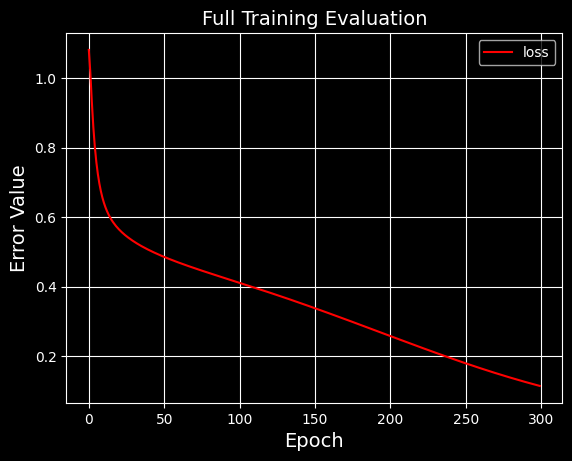

In [17]:
plt.plot(losses_2, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**G. Testing the Network**

In [18]:
model_2 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_2.pth")
model_2.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [19]:
y_test1

tensor([1, 2, 2,  ..., 1, 2, 1])

Using the same `X_test_vec` and `y_test1` we applied on `model_1`.

In [20]:
predictions_2 = model_2.forward(X_test_vec)
predictions_2 = torch.softmax(predictions_2, dim=1)
predictions_2 = torch.argmax(predictions_2, dim=1)
predictions_2

tensor([1, 2, 2,  ..., 1, 2, 1])

In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test1, predictions_2)
accuracy

0.9012581781580272

In [22]:
from sklearn.metrics import recall_score

recall = recall_score(y_test1, predictions_2, average='macro')
recall

0.894345202962174

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test1, predictions_2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1550
           1       0.90      0.90      0.90      4451
           2       0.90      0.91      0.91      3934

    accuracy                           0.90      9935
   macro avg       0.90      0.89      0.90      9935
weighted avg       0.90      0.90      0.90      9935



Using its own test set: `X_test` and `y_test2`

In [24]:
predictions_3 = model_2.forward(X_test)
predictions_3 = torch.softmax(predictions_3, dim=1)
predictions_3 = torch.argmax(predictions_3, dim=1)
predictions_3

tensor([0, 0, 2,  ..., 0, 1, 2])

In [25]:
y_test2

tensor([0, 0, 2,  ..., 0, 1, 0])

In [26]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test2, predictions_3)
accuracy

0.6926623737975992

In [27]:
from sklearn.metrics import recall_score

recall = recall_score(y_test2, predictions_3, average='macro')
recall

0.6932215208895203

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, predictions_3))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4193
           1       0.61      0.63      0.62      4452
           2       0.65      0.66      0.65      3934

    accuracy                           0.69     12579
   macro avg       0.70      0.69      0.69     12579
weighted avg       0.70      0.69      0.69     12579



In the end, our `model_2` has an improved performance over `model_1`. Although not shown in the current notebook, at the same 100 epochs of training, model_2 received `74%` on Macro-recall, `74%` on Macro-F1, and `75%` on Accuracy. This results are better than what `model_1` achieved. On the other hand, it got `70%` on all metrics when tested on its own test set, `y_test2`. So it can be concluded that performing resampling on the `Negative` class helped the neural network to learn much better. 

`Model_2` was trained for 300 epochs so that it can have more time to adjust its weights and learn better, until it arrived on its final performance of:

`y_test1`
* Macro-Recall = `89.43%`
* Macro-F1 =    `89.67%`
* Accuracy =    `90.13%`

`y_test2`
* Macro-Recall = `69.32%`
* Macro-F1 =    `69.33%`
* Accuracy =    `69.27%`

It may or may not have seen already the data from the test set we have used on `model_1`, because of the random nature of splitting, So `model_2` was also tested against its own test set, `y_test2`, and achieved close to 70% performance on all metrics.

Although the model is not improving any better on its own test set even for an additional 200 epochs, it can be concluded that it is still capable of getting right 70% on classifying the correct sentiment of an unseen text, and 30% of the time it will classify it wrong.

#### **End. Thank you!**